In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import tensorflow as tf
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support

## Load Dataset

In [2]:
datamining_dir = "./"

X_train = np.load(datamining_dir + "train_X.npy")
X_test = np.load(datamining_dir + "test_X.npy")
y_train = np.load(datamining_dir + "train_Y.npy")
y_test = np.load(datamining_dir + "test_Y.npy")

X_train_imgs = np.stack((X_train, X_train, X_train), axis=3)
X_test_imgs = np.stack((X_test, X_test, X_test), axis=3)


print("X_train shape ", X_train_imgs.shape)
print("y_train shape ", y_train.shape)
print("X_test shape ", X_test_imgs.shape)
print("y_test shape ", y_test.shape)

X_train shape  (16653, 64, 64, 3)
y_train shape  (16653,)
X_test shape  (4163, 64, 64, 3)
y_test shape  (4163,)


## Preparing Feature Extractor Model

In [3]:
from keras.applications.resnet50 import ResNet50
from keras.models import Model

dims = 64
resnet = ResNet50(include_top=False, input_shape=(dims, dims, 3))

for layer in resnet.layers:
    layer.trainable = False
    
model = tf.keras.layers.Flatten()(resnet.output)
model = Model(resnet.input, model)

print(model.summary())

2021-07-24 12:39:42.230243: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-07-24 12:39:42.311560: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-07-24 12:39:42.312074: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1650 computeCapability: 7.5
coreClock: 1.56GHz coreCount: 16 deviceMemorySize: 3.82GiB deviceMemoryBandwidth: 119.24GiB/s
2021-07-24 12:39:42.312207: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-07-24 12:39:42.344975: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic l

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
__________________________________________________________________________________________________
None


## Extracting Features via ResNet50 CNN

In [4]:
X_train_out = model.predict(X_train_imgs)
X_test_out = model.predict(X_test_imgs)

print("X_train_out shape ", X_train_out.shape)
print("X_test_out shape ", X_test_out.shape)

2021-07-24 12:39:43.552780: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 818528256 exceeds 10% of free system memory.
2021-07-24 12:39:43.990251: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-07-24 12:39:44.010030: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2599990000 Hz


X_train_out shape  (16653, 8192)
X_test_out shape  (4163, 8192)


## Applying PCA on extracted features

In [5]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 0.8)
pca.fit(X_train_out)

X_train_red = pca.transform(X_train_out)
X_test_red = pca.transform(X_test_out)

print("X_train_red shape ", X_train_red.shape)
print("X_test_red shape ", X_test_red.shape)

X_train_red shape  (16653, 86)
X_test_red shape  (4163, 86)


In [6]:
accuracies = {}
precisions = {}
recalls = {}
fscores = {}

## Fit KNN Classifier

In [7]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn.fit(X_train_out, y_train)

acc = knn.score(X_test_out, y_test)
y_pred = knn.predict(X_test_out)
print("Accuracy ", acc*100)

precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred)

accuracies['knn'] = acc*100
precisions['knn'] = precision[0]*100
recalls['knn'] = recall[0]*100
fscores['knn'] = fscore[0]*100

Accuracy  89.02233965889982


In [9]:
knn_pca = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn_pca.fit(X_train_red, y_train)

acc = knn_pca.score(X_test_red, y_test)
y_pred = knn_pca.predict(X_test_red)
print("Accuracy ", acc*100)

precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred)

accuracies['knn_pca'] = acc*100
precisions['knn_pca'] = precision[0]*100
recalls['knn_pca'] = recall[0]*100
fscores['knn_pca'] = fscore[0]*100

Accuracy  87.24477540235407


## Fit SVM Classifier

In [10]:
from sklearn import svm

svmc = svm.SVC(kernel='linear').fit(X_train_out, y_train)
acc = svmc.score(X_test_out, y_test)
y_pred = svmc.predict(X_test_out)
print("Accuracy ", acc*100)

precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred)

accuracies['svm'] = acc*100
precisions['svm'] = precision[0]*100
recalls['svm'] = recall[0]*100
fscores['svm'] = fscore[0]*100

Accuracy  83.85779485947634


In [11]:
svm_pca = svm.SVC(kernel='linear').fit(X_train_red, y_train)
acc = svm_pca.score(X_test_red, y_test)
y_pred = svm_pca.predict(X_test_red)
print("Accuracy ", acc*100)

precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred)

accuracies['svm_pca'] = acc*100
precisions['svm_pca'] = precision[0]*100
recalls['svm_pca'] = recall[0]*100
fscores['svm_pca'] = fscore[0]*100

Accuracy  76.81960124909921


## Fit DNN Model

In [19]:
from keras.applications.resnet50 import ResNet50
from keras.models import Model

dims = 64
resnet = ResNet50(include_top=False, input_shape=(dims, dims, 3))

for layer in resnet.layers:
    layer.trainable = False

## Extending resnet model to train a DNN
dnn = tf.keras.layers.Flatten()(resnet.output)
dnn = tf.keras.layers.Dense(512, activation='relu')(dnn)
dnn = tf.keras.layers.Dense(256, activation='relu')(dnn)
dnn = tf.keras.layers.Dense(256, activation='relu')(dnn)
dnn = tf.keras.layers.Dense(1, activation='sigmoid')(dnn)

dnn_model = Model(resnet.input, dnn)

dnn_model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss = 'binary_crossentropy',metrics = ['acc'])
dnn_model.fit(X_train_imgs, y_train, validation_split=0.2, epochs=10, steps_per_epoch = 100)

score, acc = dnn_model.evaluate(X_test_imgs, y_test)
y_pred = dnn_model.predict(X_test_imgs)
print("Accuracy ", acc*100)

y_pred = np.around(y_pred.reshape(y_test.shape))
precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred)

accuracies['dnn'] = acc*100
precisions['dnn'] = precision[0]*100
recalls['dnn'] = recall[0]*100
fscores['dnn'] = fscore[0]*100

Epoch 1/10
100/100 [==============================] - 46s 439ms/step - loss: 0.7845 - acc: 0.6812 - val_loss: 0.4716 - val_acc: 0.7766
Epoch 2/10
100/100 [==============================] - 45s 455ms/step - loss: 0.4324 - acc: 0.7976 - val_loss: 0.4327 - val_acc: 0.7992
Epoch 3/10
100/100 [==============================] - 46s 460ms/step - loss: 0.3602 - acc: 0.8384 - val_loss: 0.4051 - val_acc: 0.8172
Epoch 4/10
100/100 [==============================] - 46s 459ms/step - loss: 0.2964 - acc: 0.8738 - val_loss: 0.4557 - val_acc: 0.8097
Epoch 5/10
100/100 [==============================] - 46s 460ms/step - loss: 0.2523 - acc: 0.8936 - val_loss: 0.3781 - val_acc: 0.8286
Epoch 6/10
100/100 [==============================] - 46s 461ms/step - loss: 0.2101 - acc: 0.9184 - val_loss: 0.2815 - val_acc: 0.8853
Epoch 7/10
100/100 [==============================] - 46s 463ms/step - loss: 0.1637 - acc: 0.9372 - val_loss: 0.3131 - val_acc: 0.8790
Epoch 8/10
100/100 [==============================] - 4

In [47]:
print(accuracies)
print(precisions)
print(recalls)
print(fscores)

df = pd.DataFrame([accuracies.values(), precisions.values(), recalls.values(), fscores.values()])
df = df.transpose()
df.columns = ['Accuracy', 'Precision', 'Recall', 'FScore']
df['model'] = accuracies.keys()
df = pd.melt(df, id_vars="model", var_name="metric", value_name="percentage")
print(df)

{'knn': 89.02233965889982, 'knn_pca': 87.24477540235407, 'svm': 83.85779485947634, 'svm_pca': 76.81960124909921, 'dnn': 84.02594327926636}
{'knn': 86.67020711630377, 'knn_pca': 85.11552928533047, 'svm': 81.58179848320694, 'svm_pca': 75.54125219426565, 'dnn': 74.9893481039625}
{'knn': 88.79216539717085, 'knn_pca': 86.18063112078346, 'svm': 81.93688792165396, 'svm_pca': 70.23939064200218, 'dnn': 95.7562568008705}
{'knn': 87.7183552808385, 'knn_pca': 85.6447688564477, 'svm': 81.75895765472312, 'svm_pca': 72.79391034677191, 'dnn': 84.10991636798089}
      model     metric  percentage
0       knn   Accuracy   89.022340
1   knn_pca   Accuracy   87.244775
2       svm   Accuracy   83.857795
3   svm_pca   Accuracy   76.819601
4       dnn   Accuracy   84.025943
5       knn  Precision   86.670207
6   knn_pca  Precision   85.115529
7       svm  Precision   81.581798
8   svm_pca  Precision   75.541252
9       dnn  Precision   74.989348
10      knn     Recall   88.792165
11  knn_pca     Recall   86.

## Plot Various Scores of all models

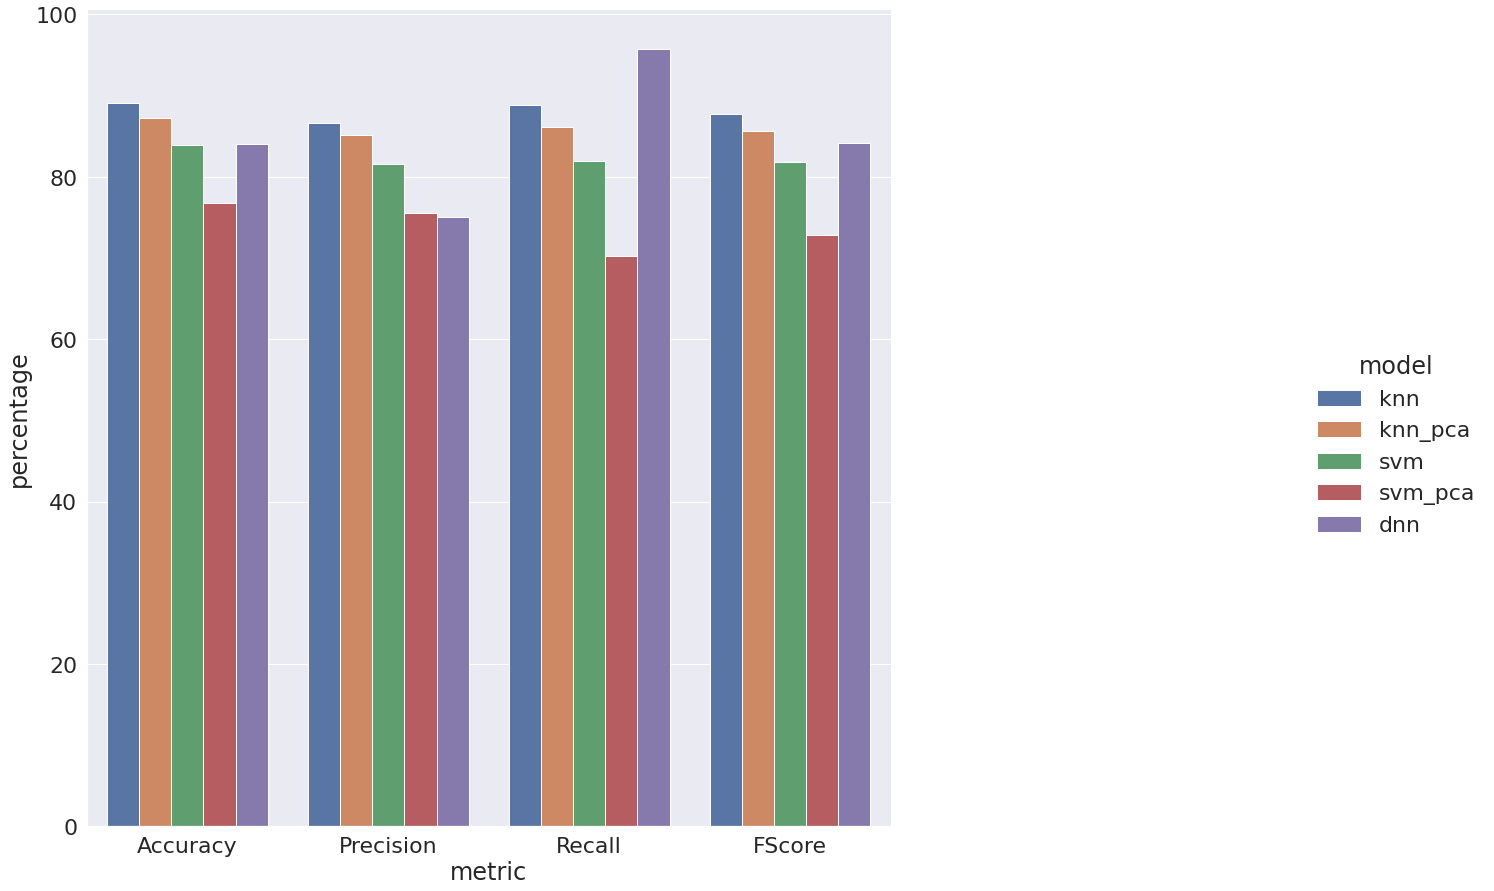

In [72]:
import seaborn as sns
sns.set(font_scale=2) 

g = sns.catplot(x='metric', y="percentage", hue="model", data=df, kind='bar')
g.fig.set_figwidth(25)
g.fig.set_figheight(15)